In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_data():
    matches = pd.read_csv("matches.csv", index_col=0)
    matches["date"] = pd.to_datetime(matches["date"])
    
    class MissingDict(dict):
        __missing__ = lambda self, key: key
    map_values = {
            "Brighton and Hove Albion" : "Brighton",
            "Manchester United" : "Manchester Utd",
            "Newcastle United" : "Newcastle Utd",
            "Tottenham Hotspur" : "Tottenham",
            "West Ham United" : "West Ham",
            "Wolverhampton Wanderers" : "Wolves",
            "West Brom" : "West Bromwich Albion",
            "Sheffield United": "Sheffield Utd",
    }
    mapping = MissingDict(**map_values)
    matches["team"] = matches["team"].map(mapping)
    matches["opponent"] = matches["opponent"].map(mapping)
    
    return matches

matches = load_data()

# Display first few rows and basic information
print("Dataset Shape:", matches.shape)
print("\nFirst few rows:")
display(matches.head())
print("\nColumns:")
display(matches.columns)

Dataset Shape: (1389, 27)

First few rows:


,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
1,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0.0,1.0,Tottenham,...,Match Report,NaN,18.0,4.0,16.9,1.0,0.0,0.0,2022,Manchester City
2,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5.0,0.0,Norwich City,...,Match Report,NaN,16.0,4.0,17.3,1.0,0.0,0.0,2022,Manchester City
3,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5.0,0.0,Arsenal,...,Match Report,NaN,25.0,10.0,14.3,0.0,0.0,0.0,2022,Manchester City
4,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1.0,0.0,Leicester City,...,Match Report,NaN,25.0,8.0,14.0,0.0,0.0,0.0,2022,Manchester City
6,2021-09-18,15:00,Premier League,Matchweek 5,Sat,Home,D,0.0,0.0,Southampton,...,Match Report,NaN,16.0,1.0,15.7,1.0,0.0,0.0,2022,Manchester City



Columns:


Index(['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation',
       'referee', 'match report', 'notes', 'sh', 'sot', 'dist', 'fk', 'pk',
       'pkatt', 'season', 'team'],
      dtype='object')

In [202]:
def validate_team_names(matches):
    all_teams = set(matches['team'].unique()) | set(matches['opponent'].unique())
    print("All unique team names in dataset:")
    for team in sorted(all_teams):
        print(f"- {team}")
    return all_teams

# Use it after loading data
matches = load_data()
team_names = validate_team_names(matches)

All unique team names in dataset:
- Arsenal
- Aston Villa
- Brentford
- Brighton
- Burnley
- Chelsea
- Crystal Palace
- Everton
- Fulham
- Leeds United
- Leicester City
- Liverpool
- Manchester City
- Manchester Utd
- Newcastle Utd
- Norwich City
- Sheffield Utd
- Southampton
- Tottenham
- Watford
- West Bromwich Albion
- West Ham
- Wolves


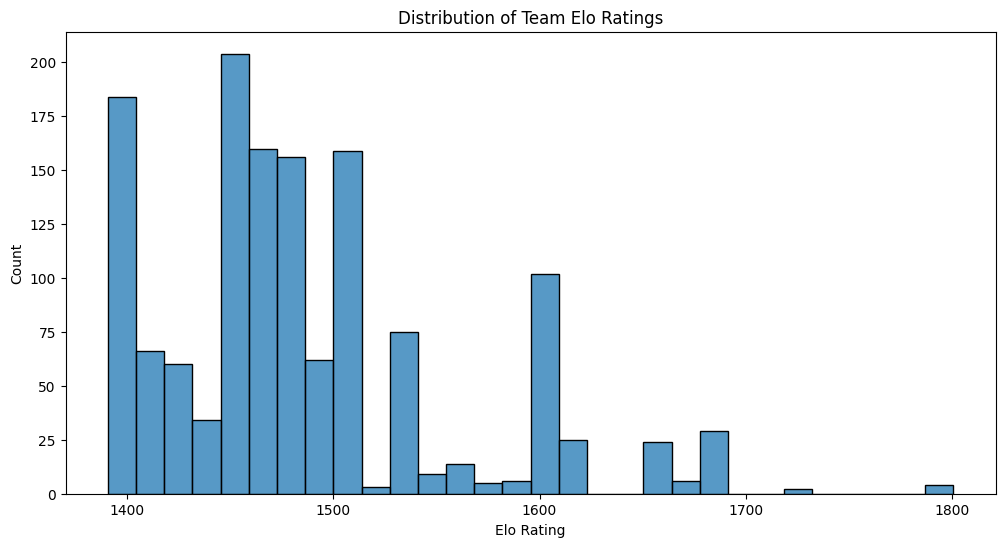

In [4]:
def calculate_elo(matches):
    # Initialize Elo ratings
    elo_dict = {}
    base_k = 32
    
    for team in matches['team'].unique():
        elo_dict[team] = {'rating': 1500, 'games_played': 0}
    
    matches = matches.sort_values('date')
    
    def dynamic_k_factor(games_played, goal_diff):
        k = base_k * (1 + abs(goal_diff) * 0.1)  # Adjust K based on margin of victory
        k *= max(0.5, min(1.0, 30 / (games_played + 1)))  # Reduce K for experienced teams
        return k
    
    def expected_score(rating_a, rating_b):
        return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))
    
    matches['team_elo'] = 0
    matches['opp_elo'] = 0
    matches['team_elo_diff'] = 0
    matches['elo_win_prob'] = 0
    
    for idx, match in matches.iterrows():
        team = match['team']
        opponent = match['opponent']
        goal_diff = match['gf'] - match['ga']
        
        # Get current Elo ratings and games played
        team_elo = elo_dict[team]['rating']
        opp_elo = elo_dict[opponent]['rating']
        team_games = elo_dict[team]['games_played']
        
        # Store Elo ratings and probabilities
        matches.at[idx, 'team_elo'] = team_elo
        matches.at[idx, 'opp_elo'] = opp_elo
        matches.at[idx, 'team_elo_diff'] = team_elo - opp_elo
        matches.at[idx, 'elo_win_prob'] = expected_score(team_elo, opp_elo)
        
        # Calculate K-factor and expected scores
        k_factor = dynamic_k_factor(team_games, goal_diff)
        team_expected = expected_score(team_elo, opp_elo)
        
        # Update Elo ratings based on actual result
        if match['result'] == 'W':
            team_actual = 1
        elif match['result'] == 'L':
            team_actual = 0
        else:
            team_actual = 0.5
        
        # Calculate new ratings with dynamic K-factor
        team_new_elo = team_elo + k_factor * (team_actual - team_expected)
        opp_new_elo = opp_elo + k_factor * ((1 - team_actual) - (1 - team_expected))
        
        # Update ratings dictionary
        elo_dict[team]['rating'] = team_new_elo
        elo_dict[team]['games_played'] += 1
        elo_dict[opponent]['rating'] = opp_new_elo
        elo_dict[opponent]['games_played'] += 1
    
    return matches

matches = calculate_elo(matches)

# Visualize Elo distributions
plt.figure(figsize=(12, 6))
sns.histplot(matches['team_elo'], bins=30)
plt.title('Distribution of Team Elo Ratings')
plt.xlabel('Elo Rating')
plt.ylabel('Count')
plt.show()

In [9]:
def add_enhanced_features(matches):
    def convert_result_to_points(result):
        return {'W': 3, 'D': 1, 'L': 0}[result]
    
    matches = matches.sort_values('date')
    matches['result_points'] = matches['result'].map(convert_result_to_points)
    
    # Multiple window sizes for form calculation
    for window in [3, 5, 7, 10]:
        matches[f'form_points_{window}'] = matches.groupby('team')['result_points'].transform(
            lambda x: x.rolling(window, min_periods=1).sum()
        )
        matches[f'form_ratio_{window}'] = matches[f'form_points_{window}'] / (window * 3)
    
    # Enhanced head-to-head features with recency weighting
    matches['h2h_wins'] = 0
    matches['h2h_draws'] = 0
    matches['h2h_losses'] = 0
    matches['recent_h2h_performance'] = 0
    
    def calculate_weighted_h2h(history, max_matches=5):
        if history.empty:
            return 0
        
        recent_matches = history.sort_values('date', ascending=False).head(max_matches)
        weights = np.exp(-np.arange(len(recent_matches)) * 0.5)  # Exponential decay
        
        result_values = recent_matches['result'].map({'W': 1, 'D': 0.5, 'L': 0})
        return np.average(result_values, weights=weights) if len(weights) > 0 else 0
    
    for idx, match in matches.iterrows():
        team = match['team']
        opponent = match['opponent']
        date = match['date']
        
        h2h_history = matches[
            (matches['date'] < date) &
            (((matches['team'] == team) & (matches['opponent'] == opponent)) |
             ((matches['team'] == opponent) & (matches['opponent'] == team)))
        ]
        
        team_matches = h2h_history[h2h_history['team'] == team]
        matches.at[idx, 'h2h_wins'] = sum(team_matches['result'] == 'W')
        matches.at[idx, 'h2h_draws'] = sum(team_matches['result'] == 'D')
        matches.at[idx, 'h2h_losses'] = sum(team_matches['result'] == 'L')
        matches.at[idx, 'recent_h2h_performance'] = calculate_weighted_h2h(team_matches)
    
    # Add goal difference streaks
    matches['goal_diff'] = matches['gf'] - matches['ga']
    for window in [3, 5, 7]:
        matches[f'goal_diff_streak_{window}'] = matches.groupby('team')['goal_diff'].transform(
            lambda x: x.rolling(window, min_periods=1).sum()
        )
    
    # Season progress feature
    matches['season'] = matches['date'].dt.year
    matches['month'] = matches['date'].dt.month
    matches['season_progress'] = matches.apply(
        lambda x: x['month'] if x['month'] >= 8 else x['month'] + 12, axis=1
    )
    matches['season_progress'] = (matches['season_progress'] - 8) / 10  # Normalize to [0,1]
    
    return matches

matches = add_form_features(matches)

In [10]:
def create_interaction_features(df):
    # Create meaningful interaction features
    df['elo_form_interaction'] = df['team_elo_diff'] * df['form_points_5']
    df['recent_performance_score'] = df['recent_h2h_performance'] * df['elo_win_prob']
    df['weighted_form'] = df['form_ratio_5'] * df['team_elo'] / 1500
    
    return df

In [12]:
def preprocess_data(matches):
    # Enhanced preprocessing pipeline
    matches = calculate_elo(matches)
    matches = add_enhanced_features(matches)
    matches = create_interaction_features(matches)
    
    # Convert categorical variables
    matches["venue_code"] = matches["venue"].astype("category").cat.codes
    matches["opp_code"] = matches["opponent"].astype("category").cat.codes
    matches["hour"] = matches["time"].str.replace(":.+","", regex=True).astype("int")
    matches["day_code"] = matches["date"].dt.dayofweek
    
    # Add target variable
    matches["target"] = matches['result'].map({'W': 1, 'D': 2, 'L': 0})
    
    # Calculate rolling averages with multiple windows
    stats_cols = ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt"]
    windows = [3, 5, 7, 10]
    
    for window in windows:
        for col in stats_cols:
            matches[f'{col}_rolling_{window}'] = matches.groupby('team')[col].transform(
                lambda x: x.rolling(window, min_periods=1).mean()
            )
            
        matches[f'goal_diff_rolling_{window}'] = (
            matches[f'gf_rolling_{window}'] - matches[f'ga_rolling_{window}']
        )
    
    return matches

matches_processed = preprocess_data(matches)
matches_processed.shape

# Display feature information
print("Processed dataset shape:", matches_processed.shape)
print("\nFeature names:")
display(matches_processed.columns)


Processed dataset shape: (1389, 94)

Feature names:


Index(['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation',
       'referee', 'match report', 'notes', 'sh', 'sot', 'dist', 'fk', 'pk',
       'pkatt', 'season', 'team', 'team_elo', 'opp_elo', 'team_elo_diff',
       'elo_win_prob', 'result_points', 'form_points_3', 'form_ratio_3',
       'form_points_5', 'form_ratio_5', 'form_points_7', 'form_ratio_7',
       'form_points_10', 'form_ratio_10', 'h2h_wins', 'h2h_draws',
       'h2h_losses', 'recent_h2h_performance', 'goal_diff',
       'goal_diff_streak_3', 'goal_diff_streak_5', 'goal_diff_streak_7',
       'month', 'season_progress', 'venue_code', 'opp_code', 'hour',
       'day_code', 'target', 'elo_form_interaction',
       'recent_performance_score', 'weighted_form', 'gf_rolling_3',
       'ga_rolling_3', 'sh_rolling_3', 'sot_rolling_3', 'dist_rolling_3',
       'fk_rolling_3', 'pk_rolling_3', 'pkatt_rolling_3',
       'goal_diff_rolling_

In [23]:
def prepare_features(matches_processed):
    # Define feature groups
    basic_features = ["venue_code", "opp_code", "hour", "day_code", "season_progress"]
    elo_features = ["team_elo", "opp_elo", "team_elo_diff", "elo_win_prob"]
    form_features = [col for col in matches_processed.columns if 'form_' in col]
    h2h_features = ["h2h_wins", "h2h_draws", "h2h_losses", "recent_h2h_performance"]
    rolling_features = [col for col in matches_processed.columns if 'rolling_' in col]
    interaction_features = ['elo_form_interaction', 'recent_performance_score', 'weighted_form']
    
    # Combine all features and ensure uniqueness
    all_features = list(dict.fromkeys(
        basic_features + 
        elo_features + 
        form_features + 
        h2h_features + 
        rolling_features + 
        interaction_features
    ))
    
    # Verify no duplicate columns
    print(f"Total number of unique features: {len(all_features)}")
    
    X = matches_processed[all_features].copy()
    y = matches_processed['target'].copy()
    
    # Verify feature uniqueness
    duplicate_cols = X.columns[X.columns.duplicated()].tolist()
    if duplicate_cols:
        print("Warning: Found duplicate columns:", duplicate_cols)
        X = X.loc[:, ~X.columns.duplicated()]
    
    return X, y, list(X.columns)



In [53]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.validation import check_is_fitted

class SklearnXGBClassifier(XGBClassifier):
    def __sklearn_tags__(self):
        return {"non_deterministic": True}

def train_enhanced_model(X, y):
    """Train model with enhanced preprocessing and cross-validation"""
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Create preprocessing pipeline
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = [col for col in X.columns if col in ['venue_code', 'opp_code']]
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    # Replace LabelEncoder with OneHotEncoder
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # Changed from sparse to sparse_output
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Update SMOTE categorical features indices after one-hot encoding
    # We'll need to calculate new categorical feature indices after one-hot encoding
    # This will be handled implicitly by SMOTENC
    
    # Create pipeline without explicit SMOTE for now (we'll add it back if needed)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SklearnXGBClassifier(
            n_estimators=1000,
            learning_rate=0.01,
            max_depth=6,
            min_child_weight=2,
            gamma=0.2,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='multi:softprob',
            num_class=3,
            random_state=42,
            tree_method='hist',
            early_stopping_rounds=None,
            eval_metric=['mlogloss', 'merror'],
        ))
    ])
    
    # Define parameter grid for tuning
    param_grid = {
        'classifier__max_depth': [5, 6, 7],
        'classifier__min_child_weight': [1, 2, 3],
        'classifier__gamma': [0.1, 0.2, 0.3],
        'classifier__learning_rate': [0.01, 0.05, 0.1]
    }
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    
    # Print results
    print("Best parameters:", grid_search.best_params_)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Loss', 'Win', 'Draw']))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Loss', 'Win', 'Draw'],
                yticklabels=['Loss', 'Win', 'Draw'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return best_model, preprocessor

In [49]:
# Load and prepare data
matches = load_data()
print("Initial dataset shape:", matches.shape)

Initial dataset shape: (1389, 27)


In [41]:
# Apply all preprocessing steps
matches_processed = preprocess_data(matches)
print("Processed dataset shape:", matches_processed.shape)

Processed dataset shape: (1389, 94)


In [54]:
# Prepare features
X, y, all_features = prepare_features(matches_processed)
print("Number of features:", len(all_features))
print("\nFeature groups:")
print("Basic features:", [f for f in all_features if f in ["venue_code", "opp_code", "hour", "day_code", "season_progress"]])
print("Elo features:", [f for f in all_features if "elo" in f])
print("Form features:", [f for f in all_features if "form" in f])
print("Head-to-head features:", [f for f in all_features if "h2h" in f])

Total number of unique features: 60
Number of features: 60

Feature groups:
Basic features: ['venue_code', 'opp_code', 'hour', 'day_code', 'season_progress']
Elo features: ['team_elo', 'opp_elo', 'team_elo_diff', 'elo_win_prob', 'elo_form_interaction']
Form features: ['form_points_3', 'form_ratio_3', 'form_points_5', 'form_ratio_5', 'form_points_7', 'form_ratio_7', 'form_points_10', 'form_ratio_10', 'elo_form_interaction', 'recent_h2h_performance', 'recent_performance_score', 'weighted_form']
Head-to-head features: ['h2h_wins', 'h2h_draws', 'h2h_losses', 'recent_h2h_performance']


In [55]:
# Train the enhanced model
best_model, preprocessor = train_enhanced_model(X, y)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [22]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': best_model.named_steps['classifier'].feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

NameError: name 'best_model' is not defined

In [213]:
print("Training set class distribution:\n", y_train.value_counts())
print("Test set class distribution:\n", y_test.value_counts())


Training set class distribution:
 0    438
1    421
2    252
Name: count, dtype: int64
Test set class distribution:
 0    110
1    105
2     63
Name: count, dtype: int64
